# Predicting Inspection Results
---

## Objectives

- I am tackling a binary classification problem involving restaurant health inspections using the data I processed in `01_EDA`. I am choosing logistic regression in the hopes that a restaurant owner could interpret the coefficients to better understand what factors of a restaurant have the highest odds of affecting the success/failure of an inspection.

- The two classes I am trying to predict will be Pass/Fail.

- I will aim to optimize my model for **recall** (*AKA sensitivity or true positive rate*) since missing a positive case (inspection failure) could have significant consequences, akin to missing a diagnosis or not detecting a dangerous item going through a metal detector.

---

### Imports

In [1]:
# Standard Libraries.
import ast
import pickle

# Non-Standard Libraries.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# SciKit-Learn.
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve)

In [13]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

---
### Load Dataset

In [14]:
# File path to read in processed data.
data_path = '../../data/processed_chicago.csv'

In [15]:
chicago = pd.read_csv(data_path)
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,average_severity,is_reinspection
0,2608132,S.K.Y.,S.K.Y.,2516847,Restaurant,Risk 1 (High),1239 W 18TH ST,2024-11-27,Standard Inspection,Pass,22. PROPER COLD HOLDING TEMPERATURES - Comment...,SKY,7,6,"[22, 51, 55, 55, 55, 56]","[9, 5, 2, 2, 2, 5]",4.166667,False
1,2608152,601 W COMPANIES,601 W COMPANIES,2988676,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2024-11-27,Required Inspection to Open,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",601 W COMPANIES,52,7,"[1, 5, 33, 36, 48, 50, 58]","[8, 10, 7, 4, 4, 6, 1]",5.714286,False
2,2608140,MC DONALD'S,MC DONALD'S,1045468,Restaurant,Risk 2 (Medium),6737 S PULASKI RD,2024-11-27,Standard Inspection,Pass,22. PROPER COLD HOLDING TEMPERATURES - Comment...,MC DONALDS,1,2,"[22, 55]","[9, 2]",5.500000,False


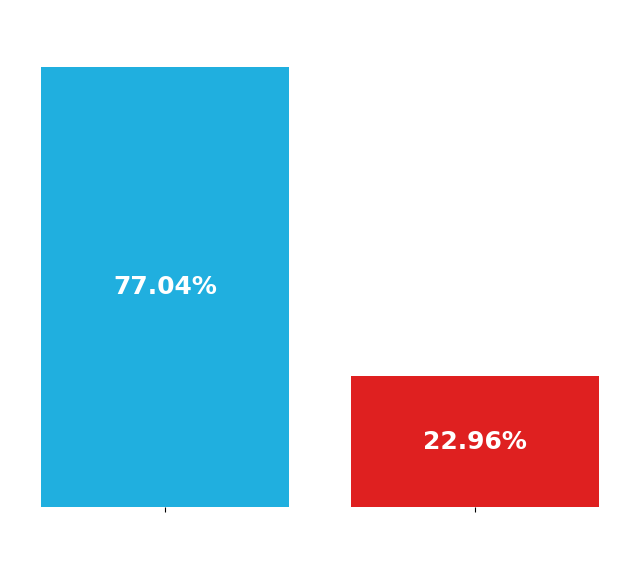

In [16]:
# Baseline Accuracy (as bar chart)
plt.figure(figsize=(8, 6))

ax = sns.barplot(x = ['(Negative Class)', '(Positive Class)'],
                 y = chicago['results'].value_counts().values,
                 palette = ['deepskyblue', 'red'],
                 hue = ['(Negative Class)', '(Positive Class)'],
                 legend = False)
# Annotated bars
for i, val in enumerate(chicago['results'].value_counts().values):
    count_norm = chicago['results'].value_counts(normalize=True)[i]
    ax.text(i, val / 2,
            f"{count_norm:.2%}",
            ha = 'center',
            va = 'center',
            fontsize = 18,
            color = 'white',
            fontweight = 'bold')

# Customization altered to match aesthetic of presentation slides.
plt.title('Class Balance', fontsize = 25, color = 'white', fontweight = 'bold')
plt.xlabel('Pass                   Fail', fontsize = 25, color = 'white', fontweight = 'bold')
plt.yticks([], [])
plt.xticks(color = 'white', fontweight = 'bold')

# Set to transparent.
ax.patch.set_alpha(0)  
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Save plot to images folder.
plt.savefig('../../images/class_balance.png');

---

- We certainly have our work cut out for us, if I were to predict the negative class every time it would give us a baseline accuracy of roughly 77% and our model's accuracy should ideally beat that.

- I have chosen `Fail` as our positive class because a `Fail` is the thing we want to detect. Much like fraud detection or a medical diagnosis, the positive class is not necessarily always a good thing.

---
# Defining Functions

In [48]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name = 'model', threshold = 0.5):
    '''
        This function calculates relevent evaluation metrics such as accuracy, precision, recall, and F1 Score for
        the train and test set and plots the ROC Curve and Confusion Matrix of a model's test predictions

        Parameters:
            model - a fitted sklearn classification model.
            X_train - explanatory variables in the train set.
            y_train - target labels in the train set.
            X_test - explanatory variables in the test set.
            y_test - target labels in the test set.
            threshold - the decision threshold for determining which label to classify based on predicted probability.
            model_name - name of model to be used for plot labels and when naming image to be exported with savefig().

        Returns:
            A dictionary 'test_metrics' with accuracy score, precision score, recall score, and F1 score of the test set.
    '''
    # Generate predictions for test and train set.
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_prob >= threshold).astype(int)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate scores for train and test set.
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred, pos_label = 1, zero_division=0),
        'Recall': recall_score(y_train, y_train_pred, pos_label = 1, zero_division=0),
        'F1 Score': f1_score(y_train, y_train_pred, pos_label = 1, zero_division=0)
    }

    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, pos_label = 1, zero_division=0)
    }
    
    # Print performance of train set.
    print('Training Scores:')
    for metric, score in train_metrics.items():
        print(f'{metric}: {score:.3f}')

    # Plot the test performance.
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Plot ROC Curve.
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label = 1)
    auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label = f'ROC Curve (AUC = {auc:.2f})', color = 'red', linewidth = 2)
    axes[0].plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'ROC Curve of {model_name}')
    axes[0].legend(loc = 'lower right')

    # Plot Confusion Matrix.
    cm = confusion_matrix(y_test, y_pred, labels = [1, 0])
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Fail', 'Pass'], yticklabels = ['Fail', 'Pass'],
                cbar = False, ax = axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title(f'Confusion Matrix of {model_name}')

    # Save plot to images folder.
    plt.savefig(f'../../images/evaluation_{model_name}.png')

    plt.tight_layout()
    plt.show()

    return test_metrics

In [18]:
def get_odds(model):
    '''
        Calculates the odds ratios for features from a logistic regression model, 
        filtering to show only features related to violation codes.
    
        Parameters:
            model - a fitted sklearn logistic regression model.
    
        Returns:
            coeff_df - a DataFrame of features and their respective odds sorted by the odds.
    '''
    features = model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.named_steps['classifier'].coef_.flatten()
    
    coeff_df = pd.DataFrame({
        'Feature': features,
        'Odds': np.exp(coefficients)
    }).sort_values(by = 'Odds', ascending = False)
    
    # Filter to only show violation codes as that's what I'd like to interpret
    coeff_df = coeff_df[coeff_df['Feature'].str.contains('violation_code')]
    # Clean up names a bit
    coeff_df['Feature'] = coeff_df['Feature'].str.replace('remainder__', '')

    return coeff_df

In [19]:
# Instantiating DataFrame to store all test results in order to be compared upon later.
model_test_results = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

---
### Preprocessing

In [20]:
# Encoding class labels (Pass = 0, Fail = 1).
chicago['results'] = chicago['results'].map({'Pass': 0, 'Fail': 1})
chicago['results'].value_counts(normalize = True)

results
0    0.77043
1    0.22957
Name: proportion, dtype: float64

In [ ]:
# ast library to allow the violation codes to be properly read.
chicago['violation_codes'] = chicago['violation_codes'].apply(ast.literal_eval)

# Flatten and get all unique violation codes.
unique_codes = sorted(set(code for codes in chicago['violation_codes'] for code in codes))

# Hard coding one-hot encoded columns due to the list-like nature of this column. Other variables will be handled by sklearn's OHE.
for code in unique_codes:
    column_name = f'violation_code_{code}'
    chicago[column_name] = chicago['violation_codes'].apply(lambda x: 1 if code in x else 0)

print(f'{chicago.shape[1]} total columns in our data set now.')

82 total columns in our data set now.


In [22]:
# Checking codes were properly encoded.
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,average_severity,is_reinspection,violation_code_1,violation_code_2,violation_code_3,violation_code_4,violation_code_5,violation_code_6,violation_code_7,violation_code_8,violation_code_9,violation_code_10,violation_code_11,violation_code_12,violation_code_13,violation_code_14,violation_code_15,violation_code_16,violation_code_17,violation_code_18,violation_code_19,violation_code_20,violation_code_21,violation_code_22,violation_code_23,violation_code_24,violation_code_25,violation_code_26,violation_code_27,violation_code_28,violation_code_29,violation_code_30,violation_code_31,violation_code_32,violation_code_33,violation_code_34,violation_code_35,violation_code_36,violation_code_37,violation_code_38,violation_code_39,violation_code_40,violation_code_41,violation_code_42,violation_code_43,violation_code_44,violation_code_45,violation_code_46,violation_code_47,violation_code_48,violation_code_49,violation_code_50,violation_code_51,violation_code_52,violation_code_53,violation_code_54,violation_code_55,violation_code_56,violation_code_57,violation_code_58,violation_code_59,violation_code_60,violation_code_61,violation_code_62,violation_code_63,violation_code_64
0,2608132,S.K.Y.,S.K.Y.,2516847,Restaurant,Risk 1 (High),1239 W 18TH ST,2024-11-27,Standard Inspection,0,22. PROPER COLD HOLDING TEMPERATURES - Comment...,SKY,7,6,"[22, 51, 55, 55, 55, 56]","[9, 5, 2, 2, 2, 5]",4.166667,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
1,2608152,601 W COMPANIES,601 W COMPANIES,2988676,Restaurant,Risk 1 (High),200 E RANDOLPH ST,2024-11-27,Required Inspection to Open,1,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",601 W COMPANIES,52,7,"[1, 5, 33, 36, 48, 50, 58]","[8, 10, 7, 4, 4, 6, 1]",5.714286,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2608140,MC DONALD'S,MC DONALD'S,1045468,Restaurant,Risk 2 (Medium),6737 S PULASKI RD,2024-11-27,Standard Inspection,0,22. PROPER COLD HOLDING TEMPERATURES - Comment...,MC DONALDS,1,2,"[22, 55]","[9, 2]",5.500000,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [23]:
# Ordinal encoding for risk.
risk_mapping = {'Risk 1 (High)': 3, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 1}
chicago['risk'] = chicago['risk'].map(risk_mapping)
chicago['risk']

0        3
1        3
2        2
3        3
4        3
        ..
62551    2
62552    3
62553    3
62554    3
62555    3
Name: risk, Length: 62556, dtype: int64

In [25]:
# Creating X and y.
X = chicago.drop(columns = ['inspection_id', 'dba_name', 'aka_name', 'license', 'facility_type', 'address', 'inspection_date', 'results',
       'violations', 'name_cleaned', 'violation_codes', 'severity_levels'])
y = chicago['results']

X.shape, y.shape

((62556, 70), (62556,))

In [26]:
# Splitting data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
# Since one-hot encoding and ordinal encoding are already applied, only scale numerical columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['num_inspections', 'violation_count', 'average_severity']),
        ('ohe', OneHotEncoder(), ['inspection_type'])
    ],
    remainder = 'passthrough'  # Keep the already preprocessed columns as they are.
)

---
# Iteration 1

### Modelling

In [28]:
# Model pipeline with Logistic Regression.
pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty = 'l2', max_iter = 1000, random_state = 42))
])

- I referenced [this article](https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451) to determine the potential best solvers.

- They do recommend the default `lbfgs` but also said to give `saga` a try if dealing with a large dataset or want to try `L1` regularization. Let's see what our first iteration finds. Then I'll narrow down to a specific solver.

- My original penalty and gridsearch was `l2` and `None`, but with no regularization my model was not converging. This is why I have selected `l2` as the penalty already when instantiating my `Logistic Regression` above. I believe this is due the fact that my dataset has multicollinearity, which I expand up later when discussing interpretations. Another possible reason could be my class imbalance, but I don't think my imbalance is that drastic to be the cause. Setting `max_iter` higher did not solve the convergence warning so I will keep `max_iter` at 1000.

In [29]:
# Hyperparameter tuning with GridSearchCV.
param_grid = {
    'classifier__C': [.001, .01, .1, 1, 10, 100, 1000], # Searching over different factors of regularization before narrowing down on one.
    'classifier__solver': ['saga', 'lbfgs']
}

grid_search_1 = GridSearchCV(pipeline_1, param_grid, cv = 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
grid_search_1.fit(X_train, y_train)

# Best model.
model_1 = grid_search_1.best_estimator_
print(f'Best Parameters: {grid_search_1.best_params_}')

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters: {'classifier__C': 1, 'classifier__solver': 'saga'}


---
### Model Evaluation

Training Scores:
Accuracy: 0.867
Precision: 0.766
Recall: 0.604
F1 Score: 0.676


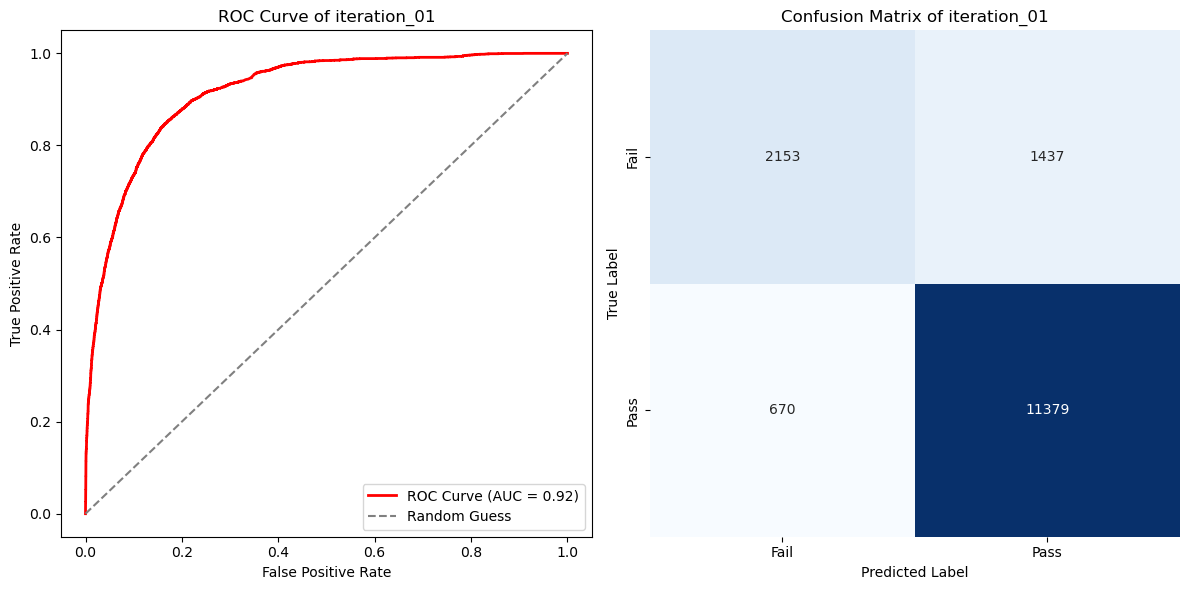

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.865273,0.762664,0.599721,0.671449
Second_Iteration_LR,0.858878,0.667150,0.768802,0.714378
Third_Iteration_LR,0.850054,0.636423,0.808914,0.712376


In [49]:
# Evaluation.
model_test_results.loc['First_Iteration_LR'] = evaluate_model(model_1, X_train, y_train, X_test, y_test, model_name = 'iteration_01') # default threshold of 0.5
model_test_results

---
### Interpretations

I must address the assumptions I could be breaking before interpreting these coefficients.

**For example:**

- **Independent Observations:** Since our dataset could have multiple inspections for a single restaurant, this could mean our observations are not independent of each other. For example, a restaurant re-inspection would be related to the first inspection in terms of what violations (*our explanatory variables*) are being examined.

- On a similar note, **multicollinearity** must be happening in our violations as they are inherently grouped by category (`Physical Facilities`, `Prevention of Food Contamination`, `Employee Health`, *etc.*). For example, if a restaurant is cited for improper reheating procedures **(Health Code 19)**, the common denominator here is an unawareness of proper temperature control which means they are likely to also not be following proper cooling procedures **(Health Code 20)**.

- **Independence of Observations** could be achieved by taking only a single random inspection from each establishment, but might run into the problem of not having enough data.

In [35]:
coeffs = get_odds(model_1)

# 10 Violation Codes with highest odds for failed inspection according to my model.
coeffs.head(10)

,Feature,Odds
71,violation_code_59,228.835706
72,violation_code_60,13.211831
50,violation_code_38,12.788898
62,violation_code_50,9.403990
60,violation_code_48,5.984398
66,violation_code_54,4.235888
37,violation_code_25,3.373262
64,violation_code_52,2.921608
28,violation_code_16,2.683062
75,violation_code_63,2.390815


**Violation Code 59:** *Previous priority foundation violation corrected*

- "Priority violations create an immediate health hazard that carry a high-risk of causing food-borne illness. Priority violations must be corrected immediately; if they cannot be corrected immediately, the license will be suspended, and the food establishment must close" [source](https://www.chicago.gov/city/en/depts/cdph/provdrs/food_safety/svcs/understand_healthcoderequirementsforfoodestablishments.html)

- My model is able to recognize one of the major reasons for failing an inspection which is a good sign.

**Violation Code 38:** *Insects, rodents, & animals not present*
- A restaurant is **12.9** times more likely to fail if there are rodents present, according to my model.

---
## Conclusion

- A suprisingly high accuracy for our first iteration of modelling. However I am not impressed with the amount of false negatives.

- In my second model I need to consider different methods for ensuring I can achieve higher recall than my first iteration, as ~60% is too low.

- For my second iteration I have introduced the threshold argument to my `evaluate_model` function and for further control of my model so hopefully I can find the sweet spot there.

- No grave differences in training and test scores to suggest gross overfitting.
---

# Iteration 2

### Modelling

In [36]:
# Model pipeline.
pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    # Going with saga according to gridsearch best parameters.
    ('classifier', LogisticRegression(solver = 'saga', max_iter = 1000, random_state = 42))
])

In [37]:
# Searching optimal alpha and testing l1 and l2 penalties.
param_grid = {
    'classifier__C': np.linspace(0.1, 2, 20), # Narrowing down on an optimal alpha around the one chosen by our last gridsearch.
    'classifier__penalty': ['l1', 'l2'] # Now that I've selected saga I will test both types of regularization.
}

grid_search_2 = GridSearchCV(pipeline_2, param_grid, cv = 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
grid_search_2.fit(X_train, y_train)

# Best model.
model_2 = grid_search_2.best_estimator_
print(f'Best Parameters: {grid_search_2.best_params_}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'classifier__C': 0.4, 'classifier__penalty': 'l1'}


---
### Model Evaluation

Training Scores:
Accuracy: 0.862
Precision: 0.672
Recall: 0.777
F1 Score: 0.721


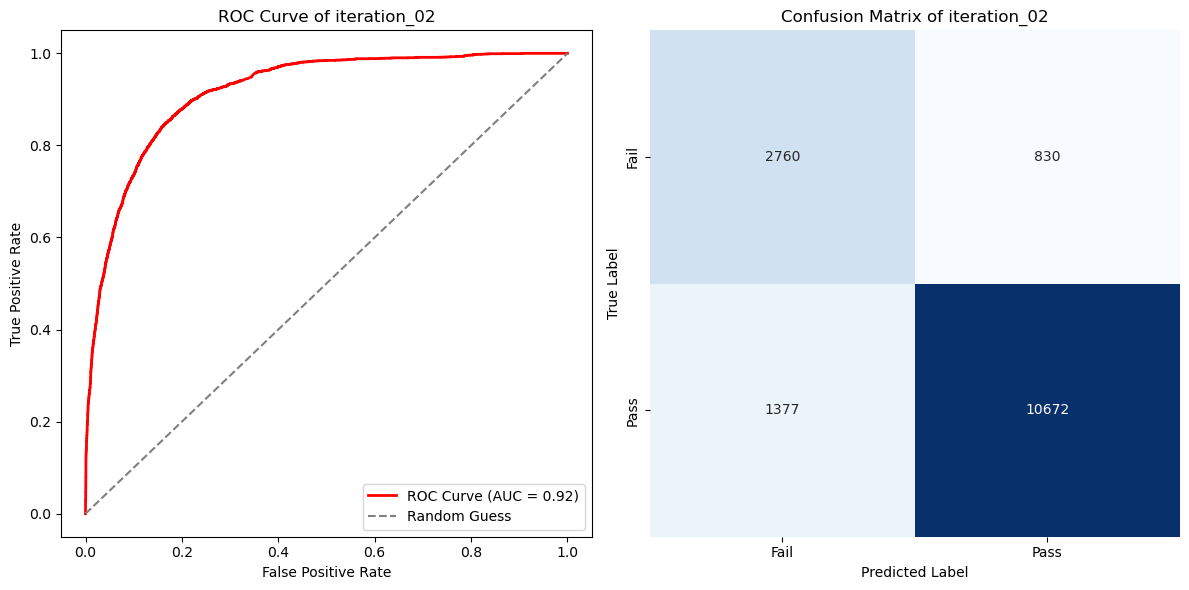

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.865273,0.762664,0.599721,0.671449
Second_Iteration_LR,0.858878,0.667150,0.768802,0.714378
Third_Iteration_LR,0.850054,0.636423,0.808914,0.712376


In [50]:
# Evaluation.
model_test_results.loc['Second_Iteration_LR'] = evaluate_model(model_2, X_train, y_train, X_test, y_test, threshold = 0.3, model_name = 'iteration_02') # Changing threshold in hopes of improving recall.
model_test_results

---
### First vs Second Iteration

- Taking advantage of `predict_proba()` to define a threshold for the predictions of my model almost halved the amount of false negatives, and while **precision** naturally takes a hit, the **recall** and overall **F1 score** have improved.

- No alarming difference in **train** and **test** scores.

- When comparing very similar types of **logistic regression** I don't expect the `AUC` to be changing that much, if at all. I had implemented the `ROC AUC` for evaluation just in case I wanted to try out extremely different types of models but moving to my final iteration I will stick with **logistic regression**.

- Given the class imbalance, an **accuracy** of **86.4%** is not as impressive as it seems seeing as we could predict `Pass` every time and get a **baseline accuracy** of roughly **76%**. However it is reassuring to know we have beat the **baseline accuracy**.

- In my final iteration of this model I will attempt  **threshold tuning**, while accounting for highest **accuracy** possible.

---
# Final Iteration (Threshold Tuning)

In [39]:
# Fit logistic regression pipeline with best parameters form Grid Search CV.
pipeline_prod = Pipeline([
    ('preprocessor', preprocessor),
    # With best parameters chosen by last GridSearchCV.
    ('classifier', LogisticRegression(C = 0.4, solver = 'saga', penalty = 'l1', max_iter = 1000, random_state = 42))
])

pipeline_prod.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['num_inspections',
                                                   'violation_count',
                                                   'average_severity']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['inspection_type'])])),
                ('classifier',
                 LogisticRegression(C=0.4, max_iter=1000, penalty='l1',
                                    random_state=42, solver='saga'))])

In [41]:
# Generate predicted probabilities.
probs = pipeline_prod.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds.
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# List comp for accuracies of each threshold, converted to numpy array so I can use some handy functions on it.
accuracies = np.array([accuracy_score(y_test, (probs >= t).astype(int)) for t in thresholds])

In [42]:
# taking advantage of numpy functions to find the thresholds where accuracy does not drop below a certain number.
accuracy_limit = 0.85

good_thresholds = np.where(accuracies >= accuracy_limit)[0] # 85 is the lowest accuracy I will accept.

best_threshold = thresholds[good_thresholds[np.argmax(recall[good_thresholds])]]

print(f'Optimal Threshold:  {best_threshold}')

Optimal Threshold:  0.23381963881179463


Training Scores:
Accuracy: 0.853
Precision: 0.641
Recall: 0.814
F1 Score: 0.717


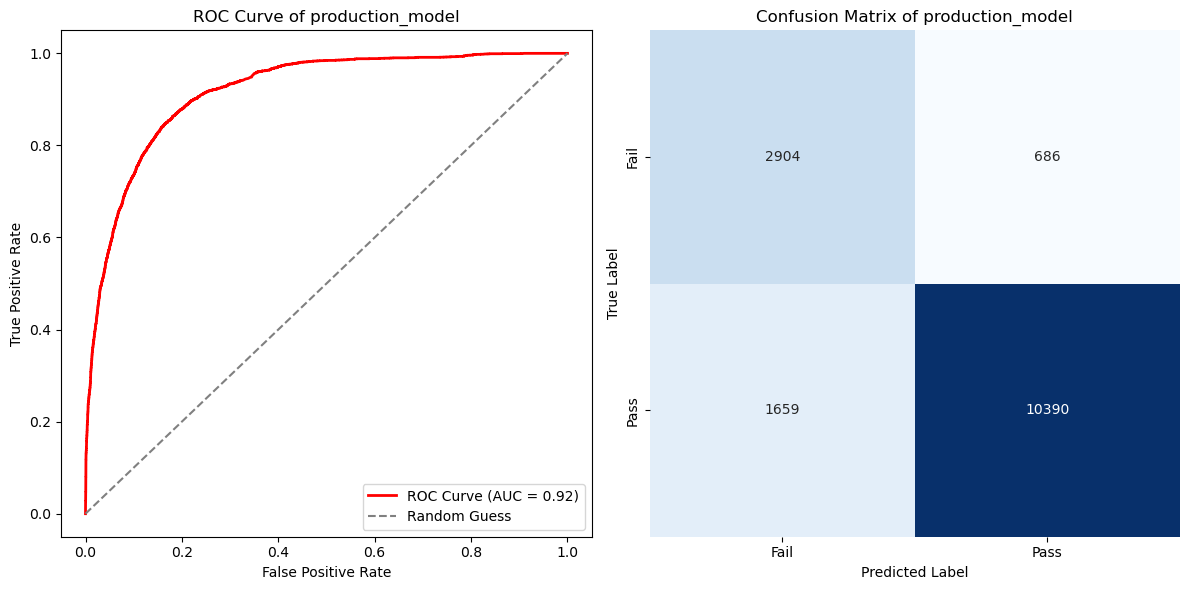

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.865273,0.762664,0.599721,0.671449
Second_Iteration_LR,0.858878,0.667150,0.768802,0.714378
Third_Iteration_LR,0.850054,0.636423,0.808914,0.712376


In [51]:
model_test_results.loc['Third_Iteration_LR'] = evaluate_model(pipeline_prod, X_train, y_train, X_test, y_test, threshold = best_threshold, model_name = 'production_model')
model_test_results

---

- I was able to find the best decision threshold without falling below a certain **accuracy** minimum, which for this trial I chose **85%**.

- I am happy to call this round of modelling done and I will move forward to developing my app demo, in the end I managed to raise the **recall** substantially which gave my **F1 score** a slight boost despite the drastic dip I took in **precision**. All the while my **accuracy** remained stable at roughly **85%**.

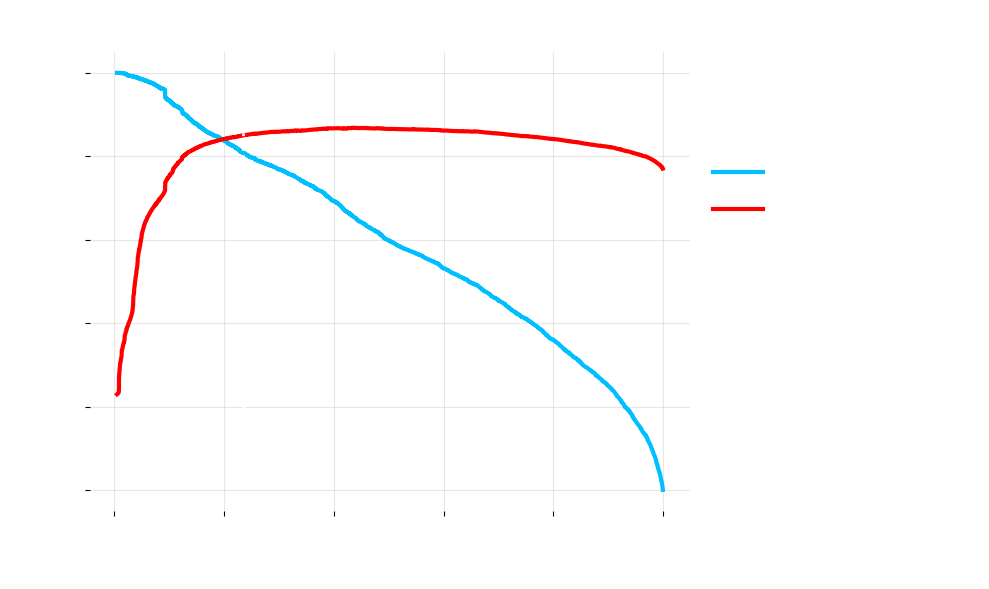

In [45]:
# Visualization of the decision threshold tuning we just calculated.
plt.figure(figsize=(10, 6))

plt.plot(thresholds, recall[:-1], label = 'Recall', color = 'deepskyblue', linewidth = 3)
plt.plot(thresholds, accuracies, label = 'Accuracy', color = 'red', linewidth = 3)
plt.axvline(best_threshold, linestyle = 'dotted', linewidth = 2, color = 'white', label = 'Best Threshold')

plt.title('Recall vs. Accuracy', size = 32, color = 'white', fontweight = 'bold')
plt.xlabel('Threshold', size = 28, color = 'white', fontweight = 'bold')
plt.ylabel('Score', size = 28, color = 'white', fontweight = 'bold')

ax = plt.gca()

plt.xticks(color = 'white', fontsize = 12)
plt.yticks(color = 'white', fontsize = 12)

plt.grid(True, alpha = 0.3)
plt.legend(loc = 'lower left', fontsize = 18, labelcolor = 'white', frameon = False, bbox_to_anchor = (1, 0.5))

# Set the plot to be transparent.
ax.patch.set_alpha(0)  
plt.gcf().patch.set_alpha(0)  

# Remove borders.
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save plot to images folder.
plt.savefig('../../images/recall_vs_accuracy.png');

---
# Modelling Conclusion

**Preprocessing:**
- Due the list-like nature of my engineered columns such as `violation_codes`, it posed a syntactical challenge in trying to get this feature matrix in the right shape and format to be fit for sklearn's libraries. That is why in the end I opted to just hard code the `OHE` for this column specifically, for the sake of time. **Hindsight is 20/20**, and having ran into these issues during the modelling and app phases of my project I would have created my features in a much different way. So that was a good learning experience.

**Modelling:**

- At first I chose **logistic regression** for the purposes of **interpretation**, so that restaurant owners could better understand what factors contribute the most to the success/failure of an inspection. Quickly I realized how many assumptions my dataset could be breaking and so **interpretations are to be taken with a grain of salt** until I research a way to solve this *assumptions* problem.

**Future Models and Ethical Considerations:**

- Is there a way to remove **multicollinearity** from these features in order for these coefficients to be interpretable? If I were to remove interpretability as a goal I could dive fully into a `black box` model. With no **interpretability** to help restaurant owners, the most effective use of this model might be on the **inspection department's** side in order to verify grades or in some way expedite the inspection process, but there could be some **very** bad consequences to that, which is why I initially steered away from that goal. I have enough experience with health inspectors to say that it is frustrating when your kitchen gets cited for some small thing just because the inspector isn't in a good mood (*or doesn't particularly like you*). A model wouldn't have this **bias** and could grade the restaurant **objectively**, which is one potential bonus. On the other hand, a model might not be able to pick up many *nuances* of the restaurant trade which **must** be taken into context when assessing potential violations. And without understanding how the model reached that conclusion, this could be a big problem **very** quickly and in fact cause **more** foodborne outbreaks or encouragement of unhealthy practices. I wouldn't even want to think of the legal problems.

---


In [46]:
# Export production model as pickle to models folder.

with open('../../models/predict_inspection.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pipeline_prod, pickle_out)